In [294]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sac_model import weights_init_
from torch.distributions import Normal
import matplotlib.pyplot as plt

In [295]:
class ThalamoCortical(nn.Module):
    def __init__(self, inp_dim, hid):
        super(ThalamoCortical, self).__init__()
        self.inp_dim = inp_dim
        self.hid = hid

        # Unload fixed weights
        weights = torch.load("checkpoints/thalamocortical_init.pth")

        # Cortical Weights
        self.J_cc = weights["Jcc"]
        self.lick_J_ct = weights["lick_Jct"]

        # Thalamic Weights
        self.lick_J_tc = weights["lick_Jtc"]

        # Thalamic Timescale (not sure what to put)
        self.tau = 1.

        # Readout for probability
        self.W_out = weights["W_out"]

        self.cortical_activity = torch.zeros(size=(hid,))
        self.c_init_mu = torch.zeros(size=(hid,))

    # TODO learn the preparatory weights and add that into the network so that each switch starts with correct initial condition
    def forward(self, x):

        # discrete dynamics with forward euler (dt = 1)
        self.thalamic_activity = self.lick_J_tc @ self.cortical_activity + x
        # make this relu just 0 or 1 instead
        print(self.cortical_activity)
        self.cortical_activity = self.J_cc @ self.cortical_activity + self.lick_J_ct @ self.thalamic_activity
        lick_prob = self.W_out @ self.cortical_activity

        return lick_prob

tensor([0., 0., 0., 0., 0., 0., 0., 0.])
tensor([-0.0150, -0.0030,  0.0188,  0.0089, -0.0042,  0.0103,  0.0202,  0.0169],
       grad_fn=<AddBackward0>)
tensor([-0.0117, -0.0217,  0.0268,  0.0156, -0.0035,  0.0213,  0.0066,  0.0027],
       grad_fn=<AddBackward0>)
tensor([-0.0174, -0.0159,  0.0386,  0.0060, -0.0104,  0.0177,  0.0100,  0.0032],
       grad_fn=<AddBackward0>)
tensor([-0.0266, -0.0239,  0.0453,  0.0108, -0.0178,  0.0268,  0.0159,  0.0077],
       grad_fn=<AddBackward0>)
tensor([-0.0287, -0.0340,  0.0554,  0.0104, -0.0203,  0.0324,  0.0126,  0.0068],
       grad_fn=<AddBackward0>)
tensor([-0.0344, -0.0369,  0.0652,  0.0080, -0.0259,  0.0364,  0.0162,  0.0071],
       grad_fn=<AddBackward0>)
tensor([-0.0404, -0.0445,  0.0739,  0.0093, -0.0308,  0.0425,  0.0179,  0.0086],
       grad_fn=<AddBackward0>)
tensor([-0.0447, -0.0511,  0.0836,  0.0084, -0.0351,  0.0477,  0.0182,  0.0086],
       grad_fn=<AddBackward0>)
tensor([-0.0502, -0.0566,  0.0929,  0.0077, -0.0402,  0.0527,  

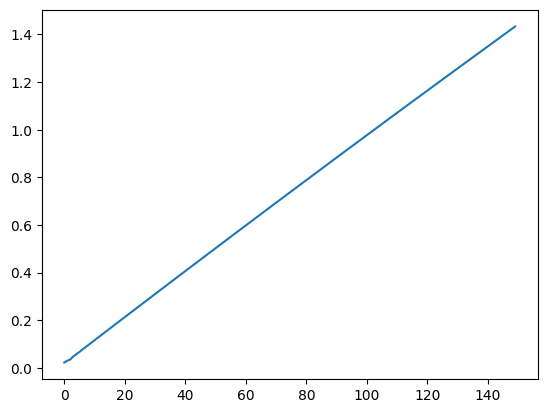

In [296]:
net = ThalamoCortical(1, 8)
test_input_lick = torch.ones(size=(int(1.5/.01),))*.1

cortical_series = []
for t in range(test_input_lick.shape[0]):
    cortical_out = net(test_input_lick[t])
    cortical_series.append(cortical_out.item())

plt.plot(cortical_series)
plt.show()